# Quick Start

This is an introduction to neural network-based survival modeling using PySaRe.

PySaRe models essentially extend the functionality of the PyTorch Module with functionality for survival analysis. Most importantly, they provide the

- Survival function
- Density function
- Hazard function
- log-likelihood

In this example it is shown how to:

- [Create a survival dataset ](#creating-survival-datasets)
- [Define a model](#defining-models)
- [Train the model](#training-models)
- [Evaluate the model](#evaluating-models)
- [Use the model](#using-models-and-the-numpy-interface)

## Creating Survival Datasets 

PySaRe works with data on the form `(X, T, E)` where:

- `X` is a n-dimensional float tensor where each element $i$ in the first dimension are the covariates/features of sample $i$. For PySaRe to work out-of-the-box, `X` must be on this format; however, it is possible to use essentially any list of objects.   
- `T` is a one-dimensional float tensor where each element is the recorded time of that sample
- `E` is a one-dimensional boolean tensor indicating if the recorded time is a recorded event (True) or censoring (False)

Datasets are implemented using the class `pysare.data.Dataset`, and there are a few pre-defined datasets available in PySaRe. Below a simulated Weibull dataset is loaded. 

In [2]:
import pysare
dataset =  pysare.data.datasets.WeibullUniformParameters(1000)
print(dataset)

PySaRe Dataset with:
  1000 individuals
  574 censored
  (2,) as shape of each individual's features


By printing the dataset it can be seen that the dataset contains 1000 individuals, out of which 570 are censored, and that the shape of the features (shape of each element in the first dimension of `X`) is 2.

`X`, `T`, and `E` are available as attributes in the dataset, and we can use this to illustrate how to create a dataset from data:

In [3]:
dataset = pysare.data.Dataset(X=dataset.X, T=dataset.T, E=dataset.E)

We finalize this section by partitioning the data into a training, validation, and test part and define the corresponding data loaders.  

In [4]:
training_set, validation_set, test_set = dataset.split((0.7,.15))

from torch.utils.data import DataLoader
training_loader = DataLoader(training_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

## Defining Models  

PySaRe models are defined much like how conventional PyTorch Modules are defined, by simply subclassing the desired model type and defining an appropriate forward method. PySaRe implements three different model types as modules, each with a number of specific models as classes in the corresponding module:
- Mixtures (`pysare.models.mixture`)
  - `GaussianMixture`
  - `WeibullMixture`
- Piecewise Models (`pysare.models.piecewise`)
  - Constant density (`ConstantDensity`)
  - Linear density (`LinearDensity`)
  - Constant hazard (`ConstantHazard`)
  - Linear hazard (`LinearHazard`)
- Energy Based (`pysare.models.energy_based`)
  - Energy based density (`EnergyBasedDensity`)


### MLP Implementations
In many cases, a multilayer perceptron network is sufficient and therefore implementations of these are readily available using the class method `MLP_implementation`. Below, a Gaussian mixture using MLP network is defined. 

In [5]:
model = pysare.models.mixture.GaussianMixture.MLP_implementation(
    num_components=5,       # Number of components in the mixture
    input_size=2,           # Size of an element of X
    hidden_sizes=(32, 32))  # Hidden layer sizes

As can be seen above, defining the MLP model requires the model specific parameter `num_components` to initialize the model. This is the case for all models; the piecewise models require a grid from `pysare.models.piecewise.grid` and the energy based models require integrators from `pysare.models.energy_based.EnergyBasedDensity`. More details on the model specific parameters can be found using the docstring for the specific model type and specific model (for example by running `help(pysare.models.piecewise)` and `help(pysare.models.piecewise.LinearDensity)`) and the publications [Piecewise](https://arxiv.org/abs/2403.18664) and [Energy Based](https://arxiv.org/abs/2302.00629).

### Custom Implementations

Defining a custom network is not much more difficult and mainly consists of defining a forward function with the correct output size. To determine the correct output size, the method `forward_output_size` can be used. Below, the MLP model above is defined using standard PyTorch modules.

In [6]:
import torch

class Model(pysare.models.mixture.GaussianMixture):
    def __init__(self) -> None:
        super().__init__() # Most models would also require some model specific 
                           # parameters to be passe to the base class
                           
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,
                            # The output from the last layer is determined
                            # using the forward_output_size method
                            self.forward_output_size(num_components=5)))

    def forward(self, X):
        return self.layers(X)

model = Model()

As can be seen above, the mixture model does not require any model specific parameters to be passed to the super class. However, the piecewise models require a grid from `pysare.models.piecewise.grid` and the energy based models require integrators from `pysare.models.energy_based.integrators`. More details on the model specific parameters can be found using the docstring for the specific model type and specific model (for example by running `help(pysare.models.piecewise)` and `help(pysare.models.piecewise.LinearDensity)`) and the publications [Piecewise](https://arxiv.org/abs/2403.18664) and [Energy Based](https://arxiv.org/abs/2302.00629).


This concludes the modeling section. For more information on how to define networks using PyTorch, PyTorch's own tutorials can be useful https://pytorch.org/tutorials/.

## Training Models 

In this section we will train the model using maximum likelihood training using the `Trainer` class from `pysare.training`. This trainer support most of the standard ways of training neural networks; however, if a more advanced training is desired, since PySaRe is implemented using PyTorch, most tools and ways of training PyTorch models can be used.

Below a PyTorch optimizer is defined in the conventional way, which is then used to define a trainer. The training is run using the data loaders defined above, and finally the training history is plotted.

Current batch:             | Previous epoch:            
 Epoch  Batch  Train. Loss |  Train. loss    Valid. loss
---------------------------------------------------------
    80      6     0.473197 |      0.51623       0.615782
---------------------------------------------------------
Training stoped at: 
   Epoch: 80  (no improvement for 50 epochs)
   Validation loss: 0.60194


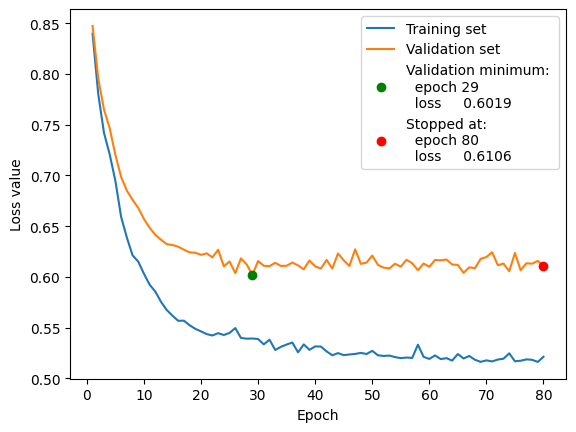

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = pysare.training.Trainer(model=model,
                                  optimizer=optimizer)

trainer.train(num_max_epochs=200,
              training_loader=training_loader,
              validation_loader=validation_loader,
              early_stopping_patience=50)

trainer.plot()

### Customized Training Loops

Since the model can provide the log-likelihood, calculating the log-likelihood is straight forward, which can be used to design a custom training procedure. Below, a single step is taken based on the mean log-likelihood of the full training set.

In [8]:
# Reset gradients
optimizer.zero_grad()

# Get the data from the training set
X, T, E = training_set[:]

# Calculate the log-likelihood
log_likelihood = model.log_likelihood(X, T, E)
print("First 10 log-likelihoods: \n", log_likelihood[:10])

# Calculate the mean
loss = log_likelihood.mean()
print("Mean log-likelihood: \n", loss)

# Calculate gradients
loss.mean().backward()

# Take the step
optimizer.step()

First 10 log-likelihoods: 
 tensor([-0.2200, -1.7625, -0.0875, -0.6518, -0.2751, -0.0384, -0.9823, -0.7704,
        -1.3962, -1.6699], grad_fn=<SliceBackward0>)
Mean log-likelihood: 
 tensor(-0.5324, grad_fn=<MeanBackward0>)


## Evaluating Models

To evaluate models, common evaluation metrics are available in the `pysare.evaluation` module. Below, the trained model is evaluated using the Brier score.

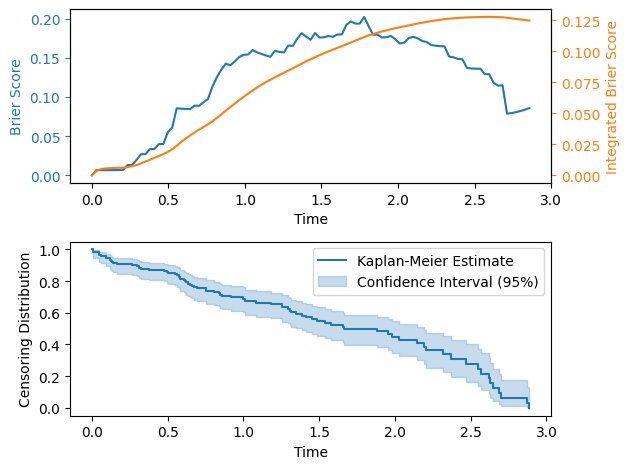

In [9]:
brier_score = pysare.evaluation.brier_score(
    model=model,        # The model
    data=test_loader,   # Data on which to evaluate, in this case a loader
    times=100,          # Number of points where the score is evaluated
    integrated=True,    # Include integrated brier score
    plot=True)          # Plot the result

By default, the brier score compensates for the censoring distribution; this makes the brier score noisy when the survival function of the censoring distribution is small, therefore censoring distribution is also plotted. 

## Using Models and the NumPy Interface

The trained model can be used as is, however, this would require the inputs to be tensors of correct `dtype`, `device` and `shape`. For this reason, PySaRe models contain a NumPy interface that allow using Numpy arrays as inputs. 

When setting up the interface, the correct type of tensors to use as inputs to the model must be determined. This can be done automatically by the interface, but it is recommended to pass a data loader when setting up the interface. By passing a data loader, its batch size will also be stored and used as maximal batch size for all calls to the underlying PyTorch model.

When using the NumPy interface, the features `X`, prediction times `T`, and indicators `E`, should be an `array_like` that after applying `numpy.array` have the following shapes:

- `X` should be an array with at least two dimensions and shape `(N, ...)`, where each of the `N` elements in the first dimension are the covariates/features from a specific individual.
- `T` should be a float array of shape `(N, 1)`, `(1, M)`, or `(M,)`
- `E` should be a boolean array of same shape as `T`.
  
Depending on the shape of `T` the inputs will be interpreted as follows:

  - If the shape is `(N, 1)` the model will be evaluated at `(X[i], T[i], E[i])` for all `i = 0, ..., N`, resulting in a result with shape `(N, 1)`.
  - If the shape is `(1, M)` the model will be evaluated at `(X[i], T[j], E[j])` for all `i = 0, ..., N` and `j = 0, ..., M`, resulting in a result of shape `(N, M)`.
  - If the shape is `(M,)` it will be interpreted the same as for `(1, M)`. 

The NumPy interface is accessed through the `to_numpy` method:

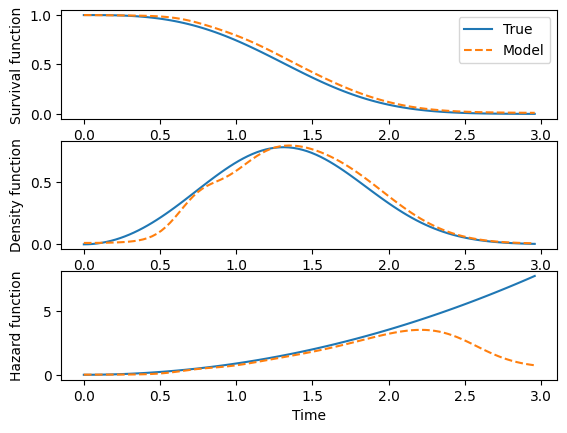

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Access the NumPy interface. 
# The validation_loader is passed to set up the interface
np_model = model.to_numpy(validation_loader)

# Create one covariate/feature vector for the model
scale = 1.5
shape = 3.
x = (shape, scale)
# x is a single covariate/feature vector and must be an element of the first
# dimension of X, therefore an extra dimension is added
X = (x,)

# Times for which to evaluate the model
T = np.linspace(0, dataset.T.max(), 100)


# For this dataset, the true distribution is known
true_model = pysare.models.distributions.Weibull().to_numpy()

fig, ax = plt.subplots(3, 1)

# Plot the survival function
ax[0].plot(T, true_model.survival_function(X, T), label = 'True')
ax[0].plot(T, np_model.survival_function(X, T), '--', label = 'Model')
ax[0].set_ylabel('Survival function')
ax[0].legend()

# Plot the density function
ax[1].plot(T, true_model.density_function(X, T))
ax[1].plot(T, np_model.density_function(X, T), '--')
ax[1].set_ylabel('Density function')

# Plot the hazard function
ax[2].plot(T, true_model.hazard_function(X, T))
ax[2].plot(T, np_model.hazard_function(X, T), '--')
ax[2].set_ylabel('Hazard function')
ax[2].set_xlabel('Time')

fig.align_labels()